In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord

plt.rcParams['font.size'] = 15
plt.rc('image', cmap='inferno', interpolation='none', origin='lower')

## Download image

I incorporate some often-used functions in a package: https://github.com/AstroJacobLi/stardenburdenhardenbart

In [5]:
from kuaizi.detection import Data
kz.utils.set_env(project='HSC', name='LSBG', data_dir='/tigress/jiaxuanl/Data')

'/tigress/jiaxuanl/Data/HSC/LSBG'

In [6]:
lsbg_cat = Table.read('./Cutout/Candy/candy_cutout_cat.fits')

In [7]:
# Download images and PSFs from HSC database
lsbg = lsbg_cat[2]
prefix = 'LSBG'
index = lsbg['Seq']
lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')

# lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
# index = lsbg['index']
size_ang = 1.0 * u.arcmin
channels = 'griz'

cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

In [8]:
# Reconstructure data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
data = Data(images=images, weights=weights, wcs=w, psfs=psfs, channels=channels)

# Detect sources

In [9]:
pixel_scale = 0.168

In [10]:
gaia_cat, msk_star = kz.utils.gaia_star_mask(  # Generate a mask for GAIA bright stars
    data.images.mean(axis=0), # averaged image
    w,
    pixel_scale=0.168,
    gaia_bright=19.5,
    mask_a=694.7, 
    mask_b=3.8,
    factor_b=1.0,
    factor_f=0.6, tigress=True)

    Taking Gaia catalogs stored in `Tigress`
    14 stars from Gaia are masked!


    Detected 139 objects


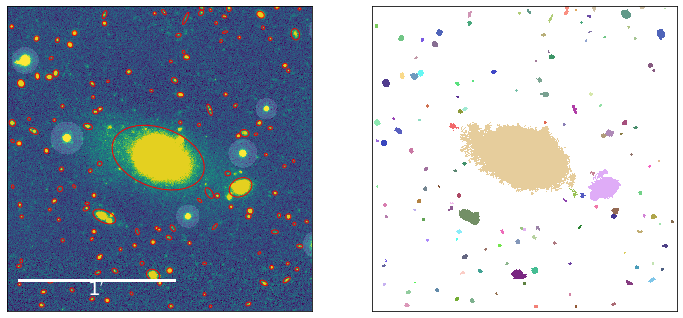

In [11]:
obj_cat_ori, segmap_ori, bg_rms = kz.detection.makeCatalog(
    [data],
    lvl=2,
    mask=msk_star,
    method='vanilla',
    convolve=False,
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=128,
    f=3,
    pixel_scale=0.168,
    minarea=20,
    deblend_nthresh=48,
    deblend_cont=0.07,
    sky_subtract=True)

catalog_c = SkyCoord(obj_cat_ori['ra'], obj_cat_ori['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
cen_indx_ori = obj_cat_ori[np.argsort(dist)[0]]['index']
cen_obj = obj_cat_ori[cen_indx_ori]
#print(f'# Central object is #{cen_indx_ori}.')
# Better position for cen_obj
x, y, _ = sep.winpos(data.images.mean(axis=0), cen_obj['x'], cen_obj['y'], 6)
ra, dec = data.wcs.wcs_pix2world(x, y, 0)
cen_obj['x'] = x
cen_obj['y'] = y
cen_obj['ra'] = ra
cen_obj['dec'] = dec

In [12]:
# We roughly guess the box size of the Starlet model
model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(data.channels))
model_frame = scarlet.Frame(
    data.images.shape,
    wcs=data.wcs, 
    psf=model_psf,
    channels=list(data.channels))
observation = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=data.weights,
    channels=list(data.channels))
observation = observation.match(model_frame)

cen_obj = obj_cat_ori[cen_indx_ori]


starlet_source = scarlet.StarletSource(model_frame,
                                       (cen_obj['ra'], cen_obj['dec']),
                                       observation,
                                       thresh=0.001,
                                       min_grad=-0.3,  # the initial guess of box size is as large as possible
                                       starlet_thresh=5e-3)

# If the initial guess of the box is way too large, set min_grad = 0.1.
if starlet_source.bbox.shape[1] > 0.75 * data.images[0].shape[0]:
    starlet_source = scarlet.StarletSource(model_frame,
                                           (cen_obj['ra'], cen_obj['dec']),
                                           observation,
                                           thresh=0.01,
                                           min_grad=0.1,  # the initial guess of box size is as large as possible
                                           starlet_thresh=5e-3)
    
starlet_extent = kz.display.get_extent(starlet_source.bbox) # [x1, x2, y1, y2]



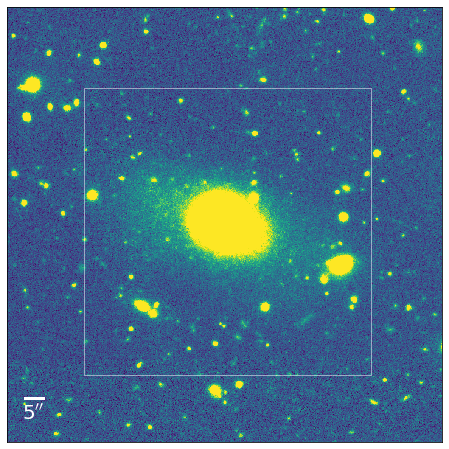

In [13]:
# Show the Starlet initial box
fig = display_single(data.images.mean(axis=0))
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "w", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
ax = plt.gca()
ax.add_patch(rect)

In [14]:
if gaia_cat is not None:
    star_flag = [(item[0] > starlet_extent[0]) & (item[0] < starlet_extent[1]) &
                (item[1] > starlet_extent[2]) & (item[1] < starlet_extent[3])
                for item in np.asarray(
                    data.wcs.wcs_world2pix(gaia_cat['ra'], gaia_cat['dec'], 0), dtype=int).T]
    star_cat = gaia_cat[star_flag] # "star_cat" is a catalog for GAIA stars which fall in the Starlet box

    _, msk_star = kz.utils.gaia_star_mask(  # Generate GAIA mask only for stars outside of the Starlet box
        data.images.mean(axis=0),
        data.wcs,
        gaia_stars=gaia_cat[~np.array(star_flag)],
        pixel_scale=0.168,
        gaia_bright=19.5,
        mask_a=694.7, 
        mask_b=3.8,
        factor_b=1.0,
        factor_f=0.6, tigress=True)
else:
    star_cat = []

    11 stars from Gaia are masked!


    Detected 53 objects


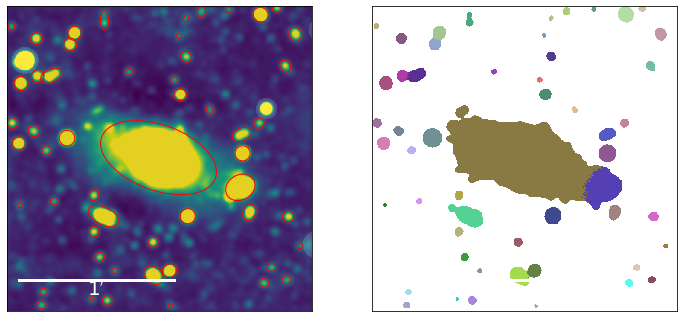

In [15]:
# This detection (after blurring the original images) finds out what is the central object and its (estimated) size
obj_cat, segmap_conv, bg_rms = kz.detection.makeCatalog(
    [data],
    mask=msk_star,
    lvl=8,
    method='wavelet',
    convolve=False,
    wavelet_lvl=5,
    low_freq_lvl=3,
    high_freq_lvl=0,
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=128,
    f=3,
    pixel_scale=0.168,
    minarea=20,
    deblend_nthresh=30,
    deblend_cont=0.01,
    sky_subtract=True)
catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
cen_indx_conv = obj_cat_ori[np.argsort(dist)[0]]['index']

In [16]:
compact_away_factor = 0.4
large_away_factor = 3.5
HSC_pixel_scale = 0.168
from astropy.convolution import convolve, Box2DKernel, Gaussian2DKernel

    Detected 247 objects


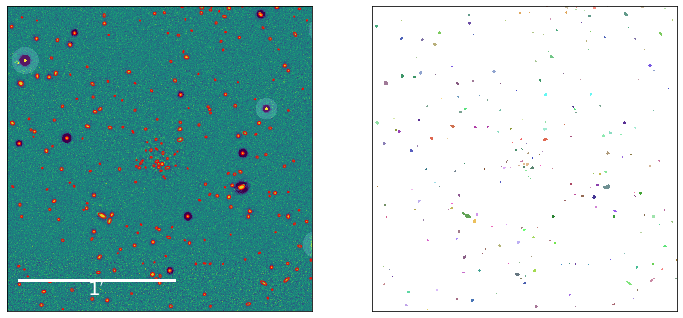

In [17]:
# This step masks out high frequency sources by doing wavelet transformation
obj_cat, segmap_highfreq, bg_rms = kz.detection.makeCatalog([data],
                                                mask=msk_star,
                                                lvl=2.,
                                                method='wavelet',
                                                high_freq_lvl=2,
                                                wavelet_lvl=4,
                                                match_gaia=False,
                                                show_fig=True,
                                                visual_gaia=False,
                                                b=24,
                                                f=2,
                                                pixel_scale=HSC_pixel_scale,
                                                minarea=3,
                                                deblend_nthresh=30,
                                                deblend_cont=0.03,
                                                sky_subtract=True)

catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
cen_indx_highfreq = obj_cat[np.argsort(dist)[0]]['index']

    # Don't mask out objects that fall in the segmap of the central object and the Starlet box
segmap = segmap_highfreq.copy()
    # overlap_flag is for objects which fall in the footprint of central galaxy in the fist SEP detection
overlap_flag = [(segmap_ori == (cen_indx_ori + 1))[item] for item in list(zip(obj_cat['y'].astype(int), obj_cat['x'].astype(int)))]
    # box_flat is for objects which fall in the initial Starlet box
overlap_flag = np.array(overlap_flag)
box_flag = np.unique(segmap[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]) - 1
if len(box_flag) > 0:
    box_flag = np.delete(np.sort(box_flag), 0)
    overlap_flag[box_flag] = True
if len(overlap_flag) > 0:
    obj_cat_cpct = obj_cat[overlap_flag]

    # Remove the source if it is the central galaxy
if dist[cen_indx_highfreq] < 1 * u.arcsec:
    obj_cat_cpct.remove_rows(np.where(obj_cat_cpct['index'] == cen_indx_highfreq)[0])

for ind in np.where(overlap_flag)[0]:
    segmap[segmap == ind + 1] = 0

smooth_radius = 2
gaussian_threshold = 0.03
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(float), Gaussian2DKernel(smooth_radius))
seg_mask = (mask_conv >= gaussian_threshold)  # This `seg_mask` only masks compact sources


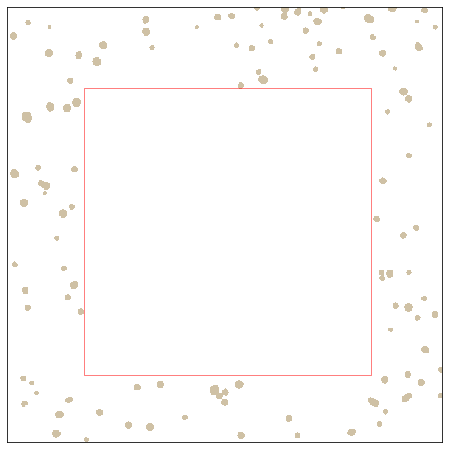

In [18]:
fig = display_single(seg_mask.astype(float), cmap=SEG_CMAP, scale='linear')
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "r", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
#print(rect)
ax = plt.gca()
ax.add_patch(rect)

    Detected 79 objects


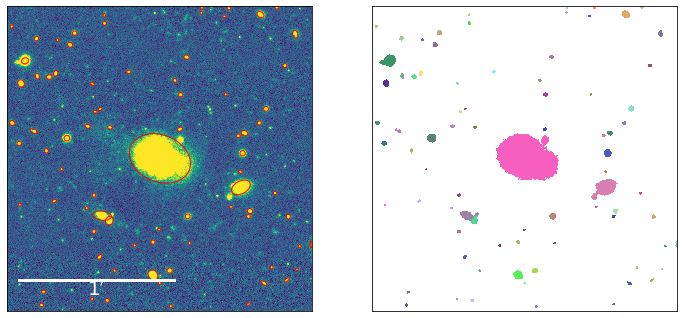

In [19]:
# This step masks out bright and large contamination, which is not well-masked in previous step
obj_cat, segmap_big, bg_rms = kz.detection.makeCatalog(
        [data],
        lvl=4.5,  # relative agressive threshold
        method='vanilla',
        match_gaia=False,
        show_fig=True,
        visual_gaia=False,
        b=45,
        f=3,
        pixel_scale=0.168,
        minarea=20,   # only want large things
        deblend_nthresh=30,
        deblend_cont=0.03,
        sky_subtract=True)

catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
cen_indx_big = obj_cat_ori[np.argsort(dist)[0]]['index']

## mask out big objects that are not identified in the high_freq step
segmap = segmap_big.copy()
box_flag = np.unique(segmap[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]) - 1
if len(box_flag) > 0:
    box_flag = np.delete(np.sort(box_flag), 0)
    for ind in box_flag:
        segmap[segmap == ind + 1] = 0
    box_flag = np.delete(box_flag, np.where(box_flag == cen_indx_big)[
                        0])  # dont include the central galaxy
    obj_cat_big = obj_cat[box_flag]
else:
    obj_cat_big = obj_cat

for ind in box_flag:
    segmap[segmap == ind + 1] = 0

smooth_radius = 5
gaussian_threshold = 0.01
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(float), Gaussian2DKernel(smooth_radius))
seg_mask_large = (mask_conv >= gaussian_threshold)  # This `seg_mask_large` masks large bright sources


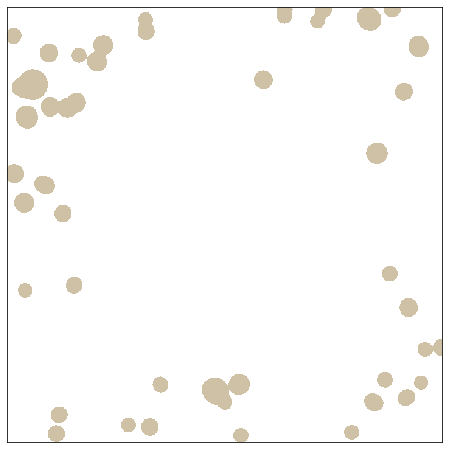

In [20]:
display_single(seg_mask_large.astype(float), scale='linear', cmap=SEG_CMAP);

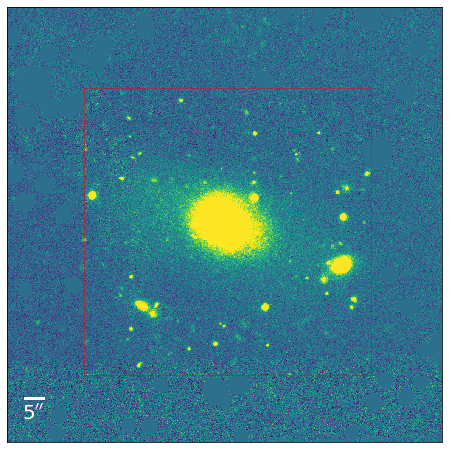

In [21]:
fig = display_single(data.images[2] * (~(seg_mask_large + seg_mask + msk_star.astype(bool))))
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "r", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
#print(rect)
ax = plt.gca()
ax.add_patch(rect)
#display_single(data.images[0] * (~(seg_mask_large + msk_star.astype(bool))));

In [22]:
# Set weights of masked pixels to zero
for layer in data.weights:
    layer[msk_star.astype(bool)] = 0
    layer[seg_mask.astype(bool)] = 0
    layer[seg_mask_large.astype(bool)] = 0

In [23]:
catalog_c = SkyCoord(obj_cat_cpct['ra'], obj_cat_cpct['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
obj_cat_cpct.remove_rows(np.where(dist < 3 * u.arcsec)[0])
    # Remove objects that are already masked!
inside_flag = [
    seg_mask_large[item] for item in list(
        zip(obj_cat_cpct['y'].astype(int), obj_cat_cpct['x'].astype(int)))
]
obj_cat_cpct.remove_rows(np.where(inside_flag)[0])
    # Remove objects that are already masked!
inside_flag = [
    (layer == 0)[item] for item in list(
        zip(obj_cat_big['y'].astype(int), obj_cat_big['x'].astype(int)))
]
obj_cat_big.remove_rows(np.where(inside_flag)[0])

# Remove big objects that are toooo near to the target
catalog_c = SkyCoord(obj_cat_big['ra'], obj_cat_big['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
obj_cat_big.remove_rows(np.where(dist < 3 * u.arcsec)[0])

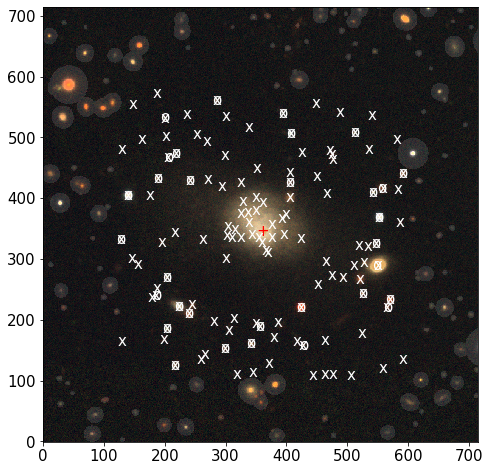

In [24]:
# Visualize our data
from scarlet.display import AsinhMapping

stretch = 2
Q = 1
img_rgb = scarlet.display.img_to_rgb(data.images, norm=AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q))
weights = data.weights
mask = (np.sum(data.weights == 0, axis=0) != 0)

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img_rgb)
plt.imshow(mask.astype(float), origin='lower', alpha=0.1, cmap='Greys_r')

# Mark all of the sources from the detection cataog
plt.text(cen_obj["x"], cen_obj["y"], '+', color="red", horizontalalignment='center', verticalalignment='center')
for k, src in enumerate(obj_cat_cpct):
    plt.text(src["x"], src["y"], 'x', color="w", horizontalalignment='center', verticalalignment='center') # src['index']
    
for k, src in enumerate(obj_cat_big):
    plt.text(src["x"], src["y"], 'o', color="w", horizontalalignment='center', verticalalignment='center') # src['index']

In [825]:
# obj_cat = obj_cat[:40]
# obj_cat.remove_rows([31, 4, 2, 1, 0])

# Model selection

In [25]:
from astropy.coordinates import match_coordinates_sky

In [26]:
# Construct `scarlet` frames and observation
from functools import partial
model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(channels))
#model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8), shape=(None, 8, 8))
model_frame = scarlet.Frame(
    data.images.shape,
    wcs=w, 
    psf=model_psf,
    channels=channels)
observation = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=data.weights,
    channels=channels)
observation = observation.match(model_frame)

In [27]:
HSC_zeropoint = 27

### Try wavelet

In [38]:
sources = []

# Add central Starlet source
src = obj_cat_ori[cen_indx_ori]
# Find a better box, not too large, not too small
for min_grad in np.arange(-0.3, 0.4, 0.05):
# for thresh in np.arange(0, 0.1, 0.02):
    starlet_source = scarlet.StarletSource(
        model_frame,
        (src['ra'], src['dec']),
        observation,
        thresh=0.01,
        min_grad=min_grad,
        starlet_thresh=0.8)
    starlet_extent = kz.display.get_extent(starlet_source.bbox)
    segbox = segmap_ori[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]
    contam_ratio = 1 - np.sum((segbox == 0) | (segbox == cen_indx_ori + 1)) / np.sum(np.ones_like(segbox))
    if contam_ratio < 0.1:
        break
print(f'min_grad = {min_grad:.2f}, contam_ratio = {contam_ratio:.2f}')
starlet_source.center = (np.array(starlet_source.bbox.shape) // 2 + starlet_source.bbox.origin)[1:]
sources.append(starlet_source)


# # Only model "real compact" sources
# if len(obj_cat_big) > 0:
#     cpct_coor = SkyCoord(
#         ra=np.array(obj_cat_cpct['ra']) * u.degree,
#         dec=np.array(obj_cat_cpct['dec']) * u.degree)
#     big = SkyCoord(ra=obj_cat_big['ra'] * u.degree, dec=obj_cat_big['dec'] * u.degree)
#     tempid, sep2d, _ = match_coordinates_sky(big, cpct_coor)
#     cpct = obj_cat_cpct[np.setdiff1d(np.arange(len(obj_cat_cpct)), tempid[np.where(sep2d < 1 * u.arcsec)])]
# else:
#     cpct = obj_cat_cpct
    
# if len(star_cat) > 0:
#     star = SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg')
#     cpct_coor = SkyCoord(
#         ra=np.array(cpct['ra']) * u.degree,
#         dec=np.array(cpct['dec']) * u.degree)
#     tempid, sep2d, _ = match_coordinates_sky(star, cpct_coor)
#     cpct = cpct[np.setdiff1d(np.arange(len(cpct)), tempid[np.where(sep2d < 1 * u.arcsec)])]

# for k, src in enumerate(cpct):
#     if src['fwhm_custom'] < 5:
#         new_source = scarlet.source.CompactExtendedSource(
#                 model_frame, (src['ra'], src['dec']), observation)
#     else:
#         new_source = scarlet.source.SingleExtendedSource(
#             model_frame, (src['ra'], src['dec']), observation, thresh=2)
#     sources.append(new_source)

# IF GAIA stars are within the box: exclude it from the big_cat
if len(obj_cat_big) > 0:
    if len(star_cat) > 0:
        star = SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg')
        tempid, sep2d, _ = match_coordinates_sky(star, big)
        big_cat = obj_cat_big[np.setdiff1d(np.arange(len(obj_cat_big)), tempid[np.where(sep2d < 1 * u.arcsec)])]
    else:
        big_cat = obj_cat_big

    for k, src in enumerate(big_cat): #[np.where(sep2d > 2 * u.arcsec)[0]]
        if src['fwhm_custom'] > 15:
            new_source = scarlet.source.ExtendedSource(
                model_frame, (src['ra'], src['dec']), observation, K=2, shifting=True)
        else:
            #try:
            new_source = scarlet.source.SingleExtendedSource(
                model_frame, (src['ra'], src['dec']), observation, thresh=2, shifting=True)
    #         except:
    #             new_source = scarlet.source.SingleExtendedSource(
    #                 model_frame, (src['ra'], src['dec']), observation, coadd=coadd, coadd_rms=bg_cutoff)
        sources.append(new_source)

if len(star_cat) > 0:
    for k, src in enumerate(star_cat):
        new_source = scarlet.source.ExtendedSource(
            model_frame, (src['ra'], src['dec']), observation, K=2)
        sources.append(new_source)

min_grad = -0.30, contam_ratio = 0.04


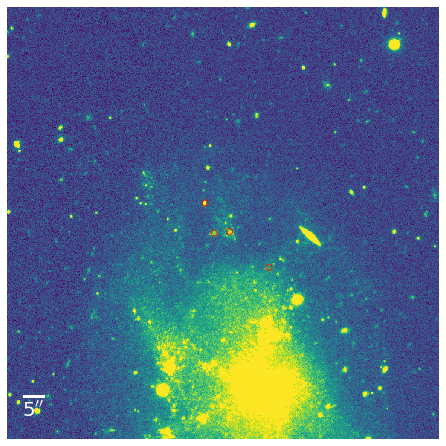

In [219]:
kz.display.draw_circles(data.images[2], big_cat, circle_size=10,) #vstack([cpct, big_cat])

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

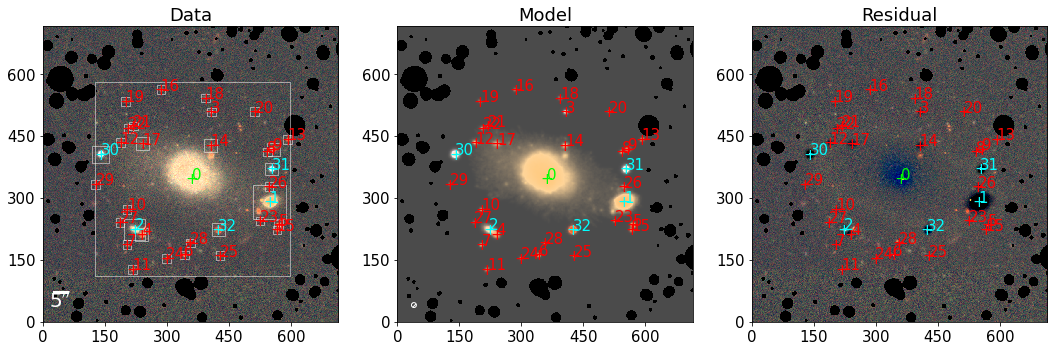

In [39]:
blend = scarlet.Blend(sources, observation)
kz.display.display_scarlet_model(
    blend,
    #zoomin_size=50,
    minimum=-0.3,
    stretch=1,
    add_boxes=True,
    channels=channels,
    show_mask=True,
    show_mark=True)

In [40]:
import dill, sys

In [41]:
sys.setrecursionlimit(10000)

In [ ]:
%%time
blend.fit(150, 1e-4)
with open(f'./Model/{prefix}-{index}-trained-model.df', 'wb') as fp:
    dill.dump([blend, {'e_rel': 1e-4}], fp)
    fp.close()
last_loss = blend.loss[-1]
print(f'Succeed for e_rel = 1e-4 with {len(blend.loss)} iterations! Try higher accuracy!')

for i, e_rel in enumerate([5e-4, 1e-5, 1e-6]):
    blend.fit(150, e_rel)
    if len(blend.loss) > 20: # must have more than 20 iterations
        recent_loss = np.mean(blend.loss[-10:])
        min_loss = np.min(blend.loss[:-10])
        if recent_loss < min_loss:
            print(f'Succeed for e_rel = {e_rel} with {len(blend.loss)} iterations! Try higher accuracy!')
            with open(f'./Model/{prefix}-{index}-trained-model.df', 'wb') as fp:
                dill.dump([blend, {'e_rel': e_rel}], fp)
                fp.close()
        elif abs((recent_loss - min_loss) / min_loss) < 0.02:
            if recent_loss < last_loss: # better than the saved model
                print(f'I am okay with relative loss difference = {abs((recent_loss - min_loss) / min_loss)}. Fitting stopped.')
                with open(f'./Model/{prefix}-{index}-trained-model.df', 'wb') as fp:
                    dill.dump([blend, {'e_rel': e_rel}], fp)
                    fp.close()
                break
        else:
            print(f'Cannot achieve a global optimization with e_rel = {e_rel}.')

Succeed for e_rel = 1e-4 with 102 iterations! Try higher accuracy!
Succeed for e_rel = 0.0005 with 104 iterations! Try higher accuracy!


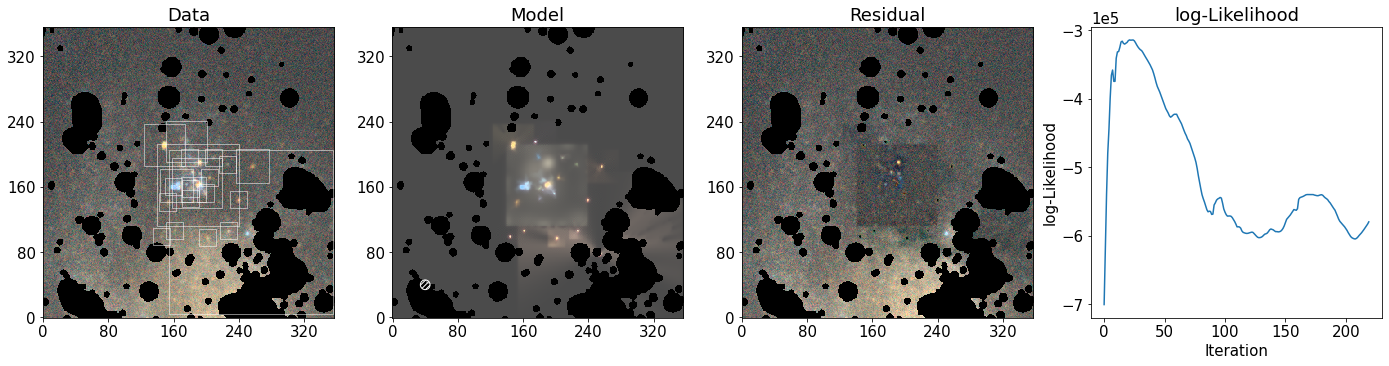

In [193]:
fig = kz.display.display_scarlet_model(
        blend,
        #show_ind=sed_ind, #range(1, len(sources)),#[1, 2, 3, 4, 5,],
        zoomin_size=60,
        minimum=-0.3,
        stretch=1,
        Q=1,
        channels='griz',
        show_loss=True,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

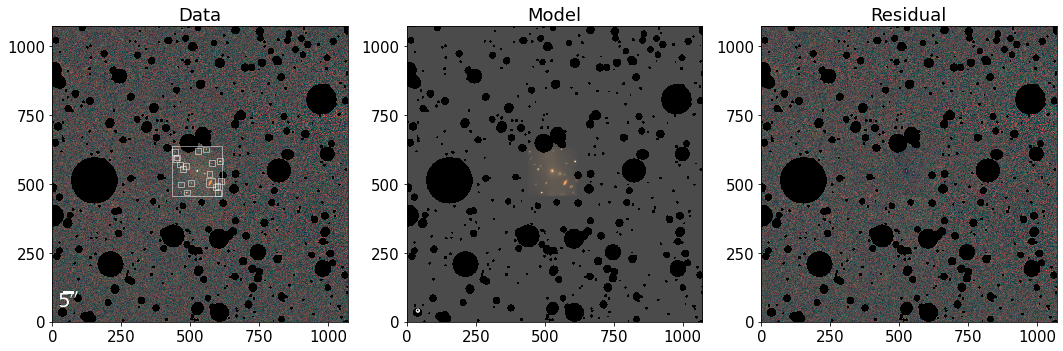

In [48]:
kz.display.display_scarlet_model(blend, minimum=-0.3, stretch=1, channels=channels, show_mask=True, show_mark=False)

In [194]:
# In principle, Now we don't need to find which components compose a galaxy. The central Starlet is enough!
if len(blend.sources) > 1:
    mag_mat = np.array([-2.5 * np.log10(kz.measure.flux(src, observation)) + 27 for src in sources])
    color_mat = (- mag_mat + mag_mat[:, 0][:, np.newaxis])[:, 1:] # g - r, g - i, g - z
    color_dist = np.linalg.norm(color_mat - color_mat[0], axis=1) / np.linalg.norm(color_mat[0])
    sed_ind = np.where(color_dist < 0.2)[0] # np.argsort(color_dist)[:]  # 
    dist = np.array([
        np.linalg.norm(src.center - blend.sources[0].center) * HSC_pixel_scale
        for src in np.array(blend.sources)[sed_ind]
    ])
    dist_flag = (dist < 3 * np.sqrt(cen_obj['a'] * cen_obj['b']) * HSC_pixel_scale)
    point_flag = np.array([
        isinstance(src, scarlet.source.PointSource)
        for src in np.array(blend.sources)[sed_ind]
    ])
    near_cen_flag = [
        (segmap_ori == cen_indx_ori +
        1)[int(src.center[0]), int(src.center[1])]
        for src in np.array(blend.sources)[sed_ind]
    ]
    sed_ind = sed_ind[(~point_flag) & near_cen_flag]

    if not 0 in sed_ind:
        sed_ind = np.array(list(set(sed_ind).union({0})))  # the central source must be included.
else:
    sed_ind = np.array([0])
print(f'Components {sed_ind} are considered as the target galaxy.')

Components [0] are considered as the target galaxy.


In [50]:
color_dist

array([0.        , 1.4456061 , 1.8482873 , 0.4322282 , 0.12161676,
       0.32561603, 0.11090378, 0.8846934 , 0.43027985, 0.39485547,
       1.0309328 , 1.0913059 , 0.43383345, 0.43152907, 0.5342536 ,
       1.0971336 , 0.3496995 , 0.31010017, 0.37133974, 0.24639761],
      dtype=float32)

IndexError: index 3 is out of bounds for axis 0 with size 3

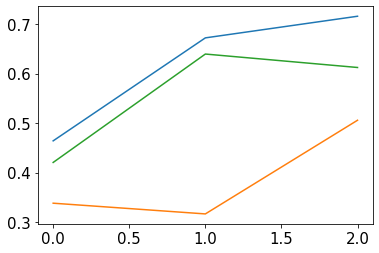

In [905]:
plt.plot(color_mat[0], label='0')
plt.plot(color_mat[1], label='1')
plt.plot(color_mat[2], label='2')
plt.plot(color_mat[3], label='3')
# plt.plot(color_mat[4], label='4')
# plt.plot(color_mat[5], label='5')
plt.legend()
plt.xlabel('colors')
plt.ylabel('mag')
plt.xticks(ticks=[0, 1, 2], labels=['g-r', 'g-i', 'g-z'])


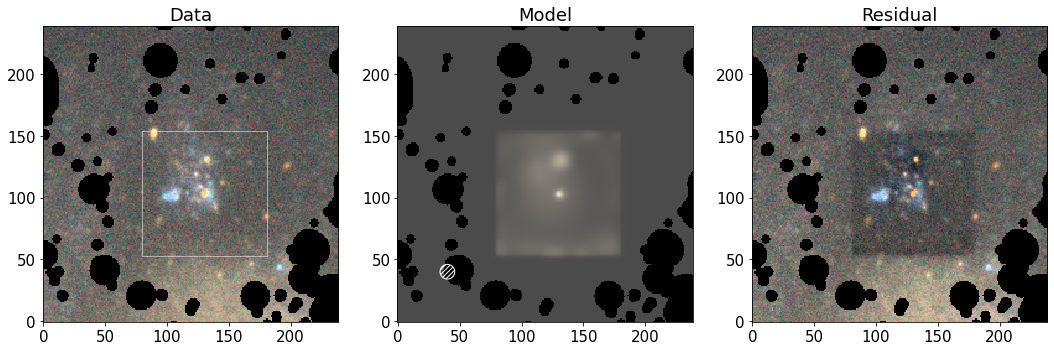

In [195]:
fig = kz.display.display_scarlet_model(
        blend,
        show_ind=sed_ind, #range(1, len(sources)),#[1, 2, 3, 4, 5,],
        zoomin_size=40,
        minimum=-0.3,
        stretch=1,
        Q=1,
        channels='griz',
        show_loss=False,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

In [52]:
# Only mask bright stars!!!

# Generate a VERY AGGRESSIVE mask, named "footprint"
footprint = np.zeros_like(segmap_highfreq, dtype=bool)
# for ind in cpct['index']:  # mask ExtendedSources which are modeled
#     footprint[segmap_highfreq == ind + 1] = 1

# footprint[segmap_highfreq == cen_indx_highfreq + 1] = 0
sed_ind_pix = np.array([item.center for item in np.array(
    sources)[sed_ind]]).astype(int)  # the y and x of sed_ind objects
# if any objects in `sed_ind` is in `segmap_highfreq`
# sed_corr_indx = segmap_highfreq[(sed_ind_pix[:, 0], sed_ind_pix[:, 1])]
# for ind in sed_corr_indx:
#     footprint[segmap_highfreq == ind] = 0

# smooth_radius = 1.5
# gaussian_threshold = 0.03
# mask_conv = np.copy(footprint)
# mask_conv[mask_conv > 0] = 1
# mask_conv = convolve(mask_conv.astype(
#     float), Gaussian2DKernel(smooth_radius))
# footprint = (mask_conv >= gaussian_threshold)

### Mask star within the box
if len(star_cat) > 0:
    _, star_mask = kz.utils.gaia_star_mask(  # Generate GAIA mask only for stars outside of the Starlet box
            data.images.mean(axis=0),
            data.wcs,
            gaia_stars=star_cat,
            pixel_scale=0.168,
            gaia_bright=18.5,
            mask_a=694.7, 
            mask_b=3.8,
            factor_b=1.0,
            factor_f=1.2)
    footprint = footprint | star_mask
    
### Mask big objects from `big_cat`
if len(obj_cat_big) > 0:
    # Blow-up radius depends on the distance to target galaxy
    catalog_c = SkyCoord(big_cat['ra'], big_cat['dec'], unit='deg')
    dist = lsbg_coord.separation(catalog_c)
    near_flag = (dist < 4 * cen_obj['a'] * HSC_pixel_scale * u.arcsec)
    
    footprint2 = np.zeros_like(segmap_big, dtype=bool)
    for ind in big_cat[near_flag]['index']:  # mask ExtendedSources which are modeled
        footprint2[segmap_big == ind + 1] = 1
    smooth_radius = 1.5
    gaussian_threshold = 0.1
    mask_conv = np.copy(footprint2)
    mask_conv[mask_conv > 0] = 1
    mask_conv = convolve(mask_conv.astype(
        float), Gaussian2DKernel(smooth_radius))
    footprint2 = (mask_conv >= gaussian_threshold)
    
    footprint3 = np.zeros_like(segmap_big, dtype=bool)
    for ind in big_cat[~near_flag]['index']:  # mask ExtendedSources which are modeled
        print(ind)
        footprint3[segmap_big == ind + 1] = 1
    smooth_radius = 5
    gaussian_threshold = 0.01
    mask_conv = np.copy(footprint3)
    mask_conv[mask_conv > 0] = 1
    mask_conv = convolve(mask_conv.astype(
        float), Gaussian2DKernel(smooth_radius))
    footprint3 = (mask_conv >= gaussian_threshold)
    
    footprint2 += footprint3 # combine together
    
        # if any objects in `sed_ind` is in `segmap_big`
    sed_corr_indx = segmap_big[sed_ind_pix[:, 0], sed_ind_pix[:, 1]]
    for ind in sed_corr_indx:
        footprint2[segmap_big == ind + 1] = 0
    footprint2[segmap_big == cen_indx_big + 1] = 0

    footprint = footprint + footprint2 # This is the mask for everything except target galaxy

93
109
155


In [53]:
# Save zoomin figure (agressively-masked, target galaxy only)
new_weights = data.weights.copy()
for layer in new_weights:
    layer[footprint.astype(bool)] = 0
observation2 = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=new_weights,
    channels=list(data.channels))
observation2 = observation2.match(model_frame)

sources = blend.sources
blend2 = scarlet.Blend(sources, observation2)

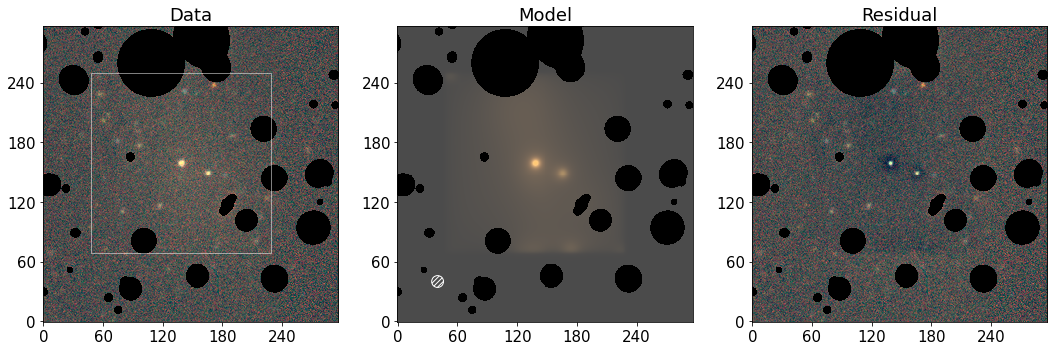

In [54]:
fig = kz.display.display_scarlet_model(
            blend2,
            show_ind=[0], #sed_ind,
            zoomin_size=50,
            minimum=-0.3,
            stretch=1,
            channels='griz',
            show_loss=False,
            show_mask=True,
            show_mark=False,
            scale_bar=False)